In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
import os


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures,MaxAbsScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, SelectFromModel
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D


import warnings
warnings.filterwarnings('ignore')



from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

In [107]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Contest/House Price/train.csv')
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [108]:
X=df.drop(columns=['SalePrice'])
y=np.log1p(df['SalePrice'])

In [109]:
X.columns = X.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

In [110]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Define ordinal mappings
        self.qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
        self.bsmt_fin_mapping = {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'None': 0}
        self.functional_mapping = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}
        self.land_slope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
        self.lot_shape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
        # Will be set in fit
        self.lotfrontage_median_ = {}
        self.neigh_tier_map_ = {}
        self.final_columns_ = []

    def fit(self, X, y=None):
        # X: DataFrame of raw features; y: target (log1p or raw). We expect y as log1p(SalePrice), so convert to raw.
        if y is not None:
            # Convert to raw SalePrice if y is log1p
            try:
                saleprice = np.expm1(y)
            except Exception:
                saleprice = y
            neigh_price = pd.Series(saleprice, index=X.index).groupby(X['Neighborhood']).mean()
            tiers = pd.qcut(neigh_price, q=3, labels=['LowTier', 'MidTier', 'HighTier'])
            self.neigh_tier_map_ = tiers.to_dict()
        else:
            self.neigh_tier_map_ = {}

        # Compute LotFrontage median per Neighborhood
        self.lotfrontage_median_ = X.groupby('Neighborhood')['LotFrontage'].median().to_dict()

        # After computing mappings, perform transform on training to record final columns
        X_eng = self._transform_df(X.copy())
        self.final_columns_ = X_eng.columns.tolist()
        return self

    def transform(self, X):
        X_eng = self._transform_df(X.copy())
        # Align columns
        X_eng = X_eng.reindex(columns=self.final_columns_, fill_value=0)
        return X_eng.values

    def _transform_df(self, df):
        df = df.copy()
        # Drop Id if present
        if 'Id' in df.columns:
            df.drop(columns=['Id'], inplace=True)

        # TotalSF
        df['TotalSF'] = df.get('1stFlrSF', 0) + df.get('2ndFlrSF', 0) + df.get('TotalBsmtSF', 0)
        # Porch
        porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
        df['TotalPorchSF'] = sum(df.get(col, 0) for col in porch_cols)
        # Bath
        df['TotalBath'] = (df.get('BsmtFullBath', 0).fillna(0) + 0.5 * df.get('BsmtHalfBath', 0).fillna(0) +
                           df.get('FullBath', 0) + 0.5 * df.get('HalfBath', 0))

        # Age, remodel, flags
        if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
            df['HouseAge'] = df['YrSold'] - df['YearBuilt']
            df['IsNew'] = (df['YearBuilt'] == df['YrSold']).astype(int)
        else:
            df['HouseAge'] = 0; df['IsNew'] = 0
        if 'YrSold' in df.columns and 'YearRemodAdd' in df.columns:
            df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
            df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
        else:
            df['RemodAge'] = 0; df['IsRemodeled'] = 0

        # Garage
        df['HasGarage'] = df.get('GarageType').notna().astype(int) if 'GarageType' in df.columns else 0
        if 'GarageYrBlt' in df.columns and 'YrSold' in df.columns:
            df['GarageYrBlt_filled'] = df['GarageYrBlt']
            df.loc[df['HasGarage']==0, 'GarageYrBlt_filled'] = df.loc[df['HasGarage']==0, 'YrSold']
            df['GarageAge'] = df['YrSold'] - df['GarageYrBlt_filled']
        else:
            df['GarageAge'] = 0

        # Flags
        df['HasPool'] = (df.get('PoolArea', 0).fillna(0) > 0).astype(int)
        df['HasFireplace'] = (df.get('Fireplaces', 0).fillna(0) > 0).astype(int)
        df['HasBasement'] = (df.get('TotalBsmtSF', 0).fillna(0) > 0).astype(int)
        df['HasWoodDeck'] = (df.get('WoodDeckSF', 0).fillna(0) > 0).astype(int)
        df['HasPorch'] = (df['TotalPorchSF'] > 0).astype(int)

        # Cyclical month sold
        if 'MoSold' in df.columns:
            df['MoSold_sin'] = np.sin(2 * np.pi * df['MoSold'] / 12)
            df['MoSold_cos'] = np.cos(2 * np.pi * df['MoSold'] / 12)

        # Impute LotFrontage by median per Neighborhood
        if 'Neighborhood' in df.columns:
            df['LotFrontage'] = df.apply(
                lambda row: row['LotFrontage'] if not pd.isna(row['LotFrontage']) else self.lotfrontage_median_.get(row['Neighborhood'], np.nan),
                axis=1
            )

        # Fill categorical “None” for absence features
        none_feats = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                      'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
        for col in none_feats:
            if col in df.columns:
                df[col] = df[col].fillna('None')

        # MasVnrArea
        if 'MasVnrArea' in df.columns and 'MasVnrType' in df.columns:
            df.loc[df['MasVnrType']=='None', 'MasVnrArea'] = 0
            df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

        # Fill Electrical/Utilities if present
        if 'Electrical' in df.columns:
            df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
        if 'Utilities' in df.columns:
            df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

        # Ordinal mappings
        ord_cols = {
            'ExterQual': self.qual_mapping, 'ExterCond': self.qual_mapping,
            'HeatingQC': self.qual_mapping, 'KitchenQual': self.qual_mapping,
            'FireplaceQu': self.qual_mapping, 'GarageQual': self.qual_mapping,
            'GarageCond': self.qual_mapping, 'PoolQC': self.qual_mapping,
            'BsmtQual': self.qual_mapping, 'BsmtCond': self.qual_mapping,
            'BsmtFinType1': self.bsmt_fin_mapping, 'BsmtFinType2': self.bsmt_fin_mapping,
            'Functional': self.functional_mapping,
            'LandSlope': self.land_slope_mapping, 'LotShape': self.lot_shape_mapping
        }
        for col, mapping in ord_cols.items():
            if col in df.columns:
                df[col + '_ord'] = df[col].map(mapping)

        # Neighborhood tier
        if 'Neighborhood' in df.columns and self.neigh_tier_map_:
            df['NeighborhoodTier'] = df['Neighborhood'].map(self.neigh_tier_map_).fillna('MidTier')
        # Drop original columns replaced or unused
        drop_cols = [
            'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageYrBlt_filled',
            '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'
        ] + porch_cols + ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'MoSold', 'YrSold', 'Id']
        if 'Utilities' in df.columns:
            drop_cols.append('Utilities')
        df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

        # One-hot encode remaining categorical columns
        obj_cols = df.select_dtypes(include=['object']).columns.tolist()
        if obj_cols:
            df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

        return df

In [111]:
pipe=Pipeline([
    ('feature_engineer',FeatureEngineer()),
    ('scaler',MaxAbsScaler()),
    ('model',XGBRegressor(
    ))
])

In [112]:
import scipy.stats as stats
param_grid={
    'model__n_estimators':stats.randint(100, 1000),
    'model__learning_rate':[0.01,0.05,0.1,0.2,0.3],
    'model__max_depth':stats.randint(3,10),
    'scaler':[StandardScaler(),RobustScaler(),QuantileTransformer(),MaxAbsScaler(),MinMaxScaler()],
    'model__subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'model__reg_lambda':[0.01,0.1,1,10,100],
    'model__reg_alpha':[0.01,0.1,1,10,100],
}
grid=RandomizedSearchCV(pipe,param_grid,cv=5,verbose=1,scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
grid.fit(X,y)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'model__learning_rate': 0.05,
 'model__max_depth': 4,
 'model__n_estimators': 876,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 100,
 'model__subsample': 0.6,
 'scaler': MaxAbsScaler()}

In [113]:
fit_params={
    'verbose':False,
    'model__n_estimators':876,
    'model__learning_rate':0.05,
    'model__max_depth':4,
    'model__subsample':0.6,
    'model__reg_lambda':100,
    'model__reg_alpha':0.1,
    'scaler':MaxAbsScaler()
}
pipe.set_params(**fit_params)
pipe.fit(X,y)

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('scaler', MaxAbsScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=876, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [114]:
y_pred_log=pipe.predict(X)

In [115]:
y_pred=np.expm1(y_pred_log)

In [116]:
print(np.sqrt(mean_squared_error(y, y_pred)))
y_true_log=np.log1p(y)
print(np.sqrt(mean_squared_error(y_true_log,y_pred_log)))

195059.61196296292
9.464902811010239


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

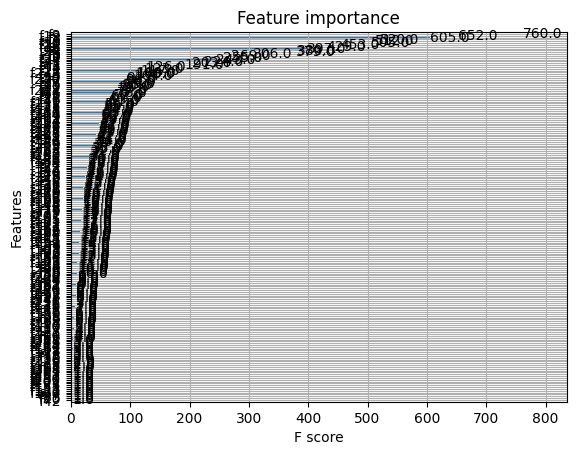

In [117]:
xgb_model=pipe.named_steps['model']
plot_importance(xgb_model)

# Neural Network

In [118]:
fe=FeatureEngineer()
x=fe.fit(X,y)
x_train=fe.transform(X)

In [119]:
scaler=MaxAbsScaler()
x_train=scaler.fit_transform(x_train)

In [120]:
model=Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1],)),
    Dense(128,'relu'),
    Dense(64,'relu'),
    Dense(32,'relu'),
    Dense(16,'relu'),
    Dense( 1,activation='linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3))
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,081 (180.00 KB)

 Trainable params: 46,081 (180.00 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [122]:
model.fit(
    x_train,y_true_log,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8029 - mse: 1.8004 - val_loss: 0.0569 - val_mse: 0.0544
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0318 - mse: 0.0294 - val_loss: 0.0164 - val_mse: 0.0140
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0088
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - mse: 0.0062 - val_loss: 0.0083 - val_mse: 0.0061
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mse: 0.0040 - val_loss: 0.0070 - val_mse: 0.0048
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mse: 0.0027 - val_loss: 0.0062 - val_mse: 0.0041
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - mse: 0.0022 - val_loss: 0.0055 - val_mse: 0.0035
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mse: 0.0019 - val_loss: 0.0051 - val_mse: 0.0031
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [123]:
yhat=model.predict(x_train)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [124]:
yhat=np.expm1(yhat)

In [125]:
print(np.sqrt(mean_squared_error(y, yhat)))

0.24364612720639767
